In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/AAP.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,73.489998,73.760002,71.690002,72.489998,71.357033,800500
1,1/3/2013,72.849998,73.440002,72.129997,72.489998,71.357033,520600
2,1/4/2013,72.750000,73.639999,72.389999,73.620003,72.469398,615000
3,1/7/2013,73.150002,73.800003,73.150002,73.370003,72.223305,1054400
4,1/8/2013,73.169998,73.660004,72.139999,72.169998,71.042053,840000


In [3]:
from collections import deque
import random


class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 10
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10, total rewards: 251.229935.3, cost: 0.077352, total money: 9325.669938
epoch: 20, total rewards: 271.560006.3, cost: 0.032282, total money: 9650.900002
epoch: 30, total rewards: 84.979950.3, cost: 0.027964, total money: 9615.889954
epoch: 40, total rewards: 164.669975.3, cost: 0.015826, total money: 9851.479973
epoch: 50, total rewards: 55.739968.3, cost: 0.014664, total money: 9897.759972
epoch: 60, total rewards: 320.429955.3, cost: 0.013052, total money: 10162.449959
epoch: 70, total rewards: 129.080002.3, cost: 0.013300, total money: 9971.100006
epoch: 80, total rewards: 196.849976.3, cost: 0.011989, total money: 10038.869980
epoch: 90, total rewards: 326.690003.3, cost: 0.013493, total money: 10326.690003
epoch: 100, total rewards: 219.489945.3, cost: 0.011178, total money: 10061.509949
epoch: 110

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 73.620003, total balance 9926.379997
day 4, sell 1 unit at price 72.169998, investment -1.969580 %, total balance 9998.549995,
day 7: buy 1 unit at price 72.290001, total balance 9926.259995
day 8: buy 1 unit at price 72.580002, total balance 9853.679993
day 10: buy 1 unit at price 73.360001, total balance 9780.319992
day 11, sell 1 unit at price 73.419998, investment 1.563145 %, total balance 9853.739990,
day 12: buy 1 unit at price 73.750000, total balance 9779.989990
day 14, sell 1 unit at price 74.750000, investment 2.989802 %, total balance 9854.739990,
day 17, sell 1 unit at price 75.940002, investment 3.516905 %, total balance 9930.679993,
day 18, sell 1 unit at price 74.570000, investment 1.111864 %, total balance 10005.249992,
day 24: buy 1 unit at price 72.900002, total balance 9932.349991
day 25: buy 1 unit at price 77.139999, total balance 9855.209991
day 27: buy 1 unit at price 78.389999, total balance 9776.819992
day 28, sell 1 unit at price 78.

day 176, sell 1 unit at price 79.379997, investment -2.084621 %, total balance 9719.749969,
day 177, sell 1 unit at price 79.720001, investment -0.075204 %, total balance 9799.469971,
day 179, sell 1 unit at price 80.360001, investment 0.904070 %, total balance 9879.829971,
day 180: buy 1 unit at price 80.709999, total balance 9799.119972
day 181: buy 1 unit at price 80.650002, total balance 9718.469971
day 182, sell 1 unit at price 79.790001, investment -1.591022 %, total balance 9798.259972,
day 183: buy 1 unit at price 80.099998, total balance 9718.159973
day 184, sell 1 unit at price 81.459999, investment 0.024554 %, total balance 9799.619972,
day 186, sell 1 unit at price 82.059998, investment 1.672653 %, total balance 9881.679970,
day 188, sell 1 unit at price 83.480003, investment 3.508992 %, total balance 9965.159973,
day 189, sell 1 unit at price 82.620003, investment 3.146073 %, total balance 10047.779976,
day 191: buy 1 unit at price 83.160004, total balance 9964.619972
day 

day 381: buy 1 unit at price 133.580002, total balance 9969.400002
day 382: buy 1 unit at price 133.160004, total balance 9836.239998
day 383, sell 1 unit at price 133.289993, investment -0.217105 %, total balance 9969.529991,
day 384: buy 1 unit at price 134.809998, total balance 9834.719994
day 385, sell 1 unit at price 132.639999, investment -0.390511 %, total balance 9967.359993,
day 387: buy 1 unit at price 129.860001, total balance 9837.499992
day 388, sell 1 unit at price 130.470001, investment -3.219343 %, total balance 9967.969994,
day 389: buy 1 unit at price 128.550003, total balance 9839.419990
day 390, sell 1 unit at price 124.150002, investment -4.397042 %, total balance 9963.569992,
day 391: buy 1 unit at price 123.589996, total balance 9839.979996
day 392, sell 1 unit at price 126.629997, investment -1.493587 %, total balance 9966.609993,
day 393, sell 1 unit at price 125.550003, investment 1.585894 %, total balance 10092.159996,
day 395: buy 1 unit at price 122.959999,

day 565, sell 1 unit at price 143.750000, investment -4.166667 %, total balance 9395.819977,
day 566: buy 1 unit at price 143.979996, total balance 9251.839981
day 567, sell 1 unit at price 145.729996, investment -2.214321 %, total balance 9397.569977,
day 568, sell 1 unit at price 146.710007, investment -1.662307 %, total balance 9544.279983,
day 569: buy 1 unit at price 148.809998, total balance 9395.469986
day 571: buy 1 unit at price 150.199997, total balance 9245.269989
day 572: buy 1 unit at price 149.179993, total balance 9096.089996
day 573: buy 1 unit at price 149.050003, total balance 8947.039993
day 574: buy 1 unit at price 149.580002, total balance 8797.459991
day 575, sell 1 unit at price 150.000000, investment 0.327741 %, total balance 8947.459991,
day 576, sell 1 unit at price 149.800003, investment 0.719429 %, total balance 9097.259994,
day 577, sell 1 unit at price 152.399994, investment 1.810402 %, total balance 9249.659988,
day 578: buy 1 unit at price 152.399994, to

day 748, sell 1 unit at price 149.649994, investment -3.965865 %, total balance 9762.770035,
day 750, sell 1 unit at price 149.059998, investment -2.708706 %, total balance 9911.830032,
day 752: buy 1 unit at price 150.550003, total balance 9761.280029
day 753: buy 1 unit at price 152.199997, total balance 9609.080032
day 755: buy 1 unit at price 150.509995, total balance 9458.570038
day 756, sell 1 unit at price 152.240005, investment 3.136647 %, total balance 9610.810043,
day 757, sell 1 unit at price 151.199997, investment -3.182430 %, total balance 9762.010040,
day 759, sell 1 unit at price 148.830002, investment -1.142478 %, total balance 9910.840042,
day 760, sell 1 unit at price 145.559998, investment -4.362680 %, total balance 10056.400040,
day 761: buy 1 unit at price 147.050003, total balance 9909.350037
day 762: buy 1 unit at price 148.070007, total balance 9761.280029
day 763, sell 1 unit at price 142.160004, investment -5.547798 %, total balance 9903.440033,
day 764: buy 1

day 930, sell 1 unit at price 153.369995, investment -2.893508 %, total balance 8970.010040,
day 931, sell 1 unit at price 151.179993, investment -5.724625 %, total balance 9121.190033,
day 932, sell 1 unit at price 150.720001, investment -3.895939 %, total balance 9271.910034,
day 933: buy 1 unit at price 148.940002, total balance 9122.970032
day 934, sell 1 unit at price 148.110001, investment -6.063295 %, total balance 9271.080033,
day 935: buy 1 unit at price 148.440002, total balance 9122.640030
day 936: buy 1 unit at price 145.889999, total balance 8976.750031
day 937: buy 1 unit at price 146.330002, total balance 8830.420029
day 938, sell 1 unit at price 149.149994, investment -6.053163 %, total balance 8979.570023,
day 939: buy 1 unit at price 149.240005, total balance 8830.330017
day 940, sell 1 unit at price 150.100006, investment -6.269510 %, total balance 8980.430023,
day 941: buy 1 unit at price 151.009995, total balance 8829.420029
day 942: buy 1 unit at price 149.000000,

day 1084, sell 1 unit at price 147.100006, investment -2.440637 %, total balance 8780.979996,
day 1085: buy 1 unit at price 145.669998, total balance 8635.309998
day 1086, sell 1 unit at price 145.779999, investment -1.366715 %, total balance 8781.089996,
day 1087: buy 1 unit at price 143.190002, total balance 8637.899994
day 1088, sell 1 unit at price 142.139999, investment -2.309279 %, total balance 8780.039993,
day 1089: buy 1 unit at price 140.529999, total balance 8639.509995
day 1090: buy 1 unit at price 142.550003, total balance 8496.959992
day 1091: buy 1 unit at price 142.820007, total balance 8354.139984
day 1092: buy 1 unit at price 144.809998, total balance 8209.329987
day 1093: buy 1 unit at price 144.979996, total balance 8064.349991
day 1094, sell 1 unit at price 146.970001, investment 2.963427 %, total balance 8211.319992,
day 1095: buy 1 unit at price 146.119995, total balance 8065.199997
day 1096: buy 1 unit at price 146.160004, total balance 7919.039993
day 1097: buy

day 1243, sell 1 unit at price 97.610001, investment 10.807134 %, total balance 7700.650009,
day 1244, sell 1 unit at price 100.309998, investment 14.235281 %, total balance 7800.960007,
day 1245: buy 1 unit at price 100.849998, total balance 7700.110009
day 1246, sell 1 unit at price 103.029999, investment 19.927825 %, total balance 7803.140007,
day 1248, sell 1 unit at price 100.199997, investment 18.931747 %, total balance 7903.340004,
day 1249: buy 1 unit at price 100.699997, total balance 7802.640007
day 1250, sell 1 unit at price 102.709999, investment 23.286523 %, total balance 7905.350006,
day 1252, sell 1 unit at price 98.589996, investment 15.107991 %, total balance 8003.940003,
day 1253: buy 1 unit at price 100.129997, total balance 7903.810005
day 1254, sell 1 unit at price 100.550003, investment 23.011996 %, total balance 8004.360009,
day 1255, sell 1 unit at price 101.959999, investment 24.813314 %, total balance 8106.320008,
day 1256: buy 1 unit at price 99.769997, total

day 1436, sell 1 unit at price 165.449997, investment -0.767708 %, total balance 9760.170029,
day 1438: buy 1 unit at price 167.649994, total balance 9592.520035
day 1441, sell 1 unit at price 168.440002, investment 0.471225 %, total balance 9760.960038,
day 1443: buy 1 unit at price 167.320007, total balance 9593.640030
day 1444, sell 1 unit at price 169.330002, investment 1.201288 %, total balance 9762.970032,
day 1450: buy 1 unit at price 165.710007, total balance 9597.260025
day 1451, sell 1 unit at price 165.830002, investment 0.072413 %, total balance 9763.090027,
day 1452: buy 1 unit at price 168.360001, total balance 9594.730027
day 1453: buy 1 unit at price 168.889999, total balance 9425.840027
day 1454, sell 1 unit at price 163.169998, investment -3.082681 %, total balance 9589.010025,
day 1455, sell 1 unit at price 161.039993, investment -4.647999 %, total balance 9750.050019,
day 1459: buy 1 unit at price 159.580002, total balance 9590.470017
day 1460, sell 1 unit at price 

day 1624: buy 1 unit at price 151.740005, total balance 8338.559968
day 1625: buy 1 unit at price 154.830002, total balance 8183.729966
day 1626: buy 1 unit at price 153.770004, total balance 8029.959962
day 1628: buy 1 unit at price 153.240005, total balance 7876.719956
day 1629, sell 1 unit at price 152.330002, investment -4.674594 %, total balance 8029.049958,
day 1630: buy 1 unit at price 154.500000, total balance 7874.549958
day 1631: buy 1 unit at price 149.929993, total balance 7724.619965
day 1633, sell 1 unit at price 154.139999, investment -0.303991 %, total balance 7878.759965,
day 1634, sell 1 unit at price 156.589996, investment 1.091028 %, total balance 8035.349961,
day 1635, sell 1 unit at price 159.789993, investment 2.858054 %, total balance 8195.139954,
day 1636: buy 1 unit at price 160.630005, total balance 8034.509949
day 1637: buy 1 unit at price 160.619995, total balance 7873.889954
day 1638, sell 1 unit at price 158.190002, investment 3.041948 %, total balance 80

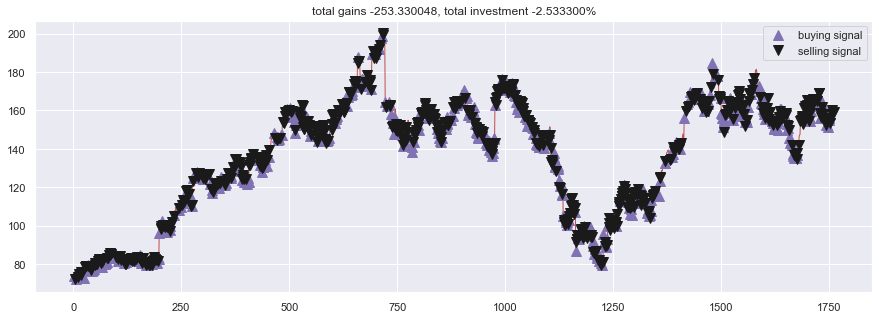

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=1)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()